# Stan: 
## _A probabilistic programming language for specifying statistical models_

### Stan interfaces:
* Command-line shell: __CmdStan__
* R: __RStan__
* Python: __PyStan__

### Dependencies for __PyStan__:
* Python: $2.7, \geq 3.3$
* Cython: $\geq 0.22$
* NumPy: $\geq 1.7$

### Setup __PyStan__:
* __conda__: manages package dependencies automatically

`conda install -c conda-forge pystan`
* __pip__:

`pip install pystan`

### Built-in inference modules:
#### MCMC samplers: 
* Hamiltonian Monte Carlo (HMC) 
* no-U-turn sampler (NUTS) (default)

#### Variational Inference:
* Automatic differentiation variational inference (ADVI) 

#### Optimizers: 
* L-BFGS (default)
* Conjugate gradient
* Newton

-----------------------------------------------------------

# Stan model:
Specified in blocks of data, parameters and model <br>
(based on C++ syntax)

## 1.) Data (Input)
* Data type (integer, real, etc)
* Dimension
* Constraints on data

## 2.) Parameters (Output)
* Parameters for our model
* Constraints on parameters

## 3.) Model
* Prior
* Likelihood
-------------------------


### Data Types
* 1-D: scalar

`int a;`  `real b;`

* N-D: (column / row) vector

`vector[N] a;`  `row_vector[N] b;`

* MxN-D: matrix

`matrix[M,N] a;`

### Constraints on data / parameters
Specify upper and lower bounds
* `int<lower=0> a;`
* `real<lower=0, upper=1> b;`

--------------------

# Examples in __PyStan__

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import arviz as az
from IPython.display import display, Math

###### Import Stan interface for Python: __PyStan__

In [2]:
import pystan

## (i) Linear regression:
#### Linear model 
$ y \sim a + b \, x  \, \Leftrightarrow \, y = a + b \, x + \epsilon$
#### Distribution
$ y \sim \mathcal{N}(a + b \, x, \sigma^2) $


##### Define model

In [3]:
linear_regression_model = """

// 1.) Data
data {
    int<lower=0> N;    // N...number of samples, N >= 0
    vector[N] x;
    vector[N] y;       // y...target, (Nx1) vector
}

// 2.) Parameters
parameters {           // params for y ~ N(a + b*x, sigma^2)
    real a;
    real b;
    real<lower=0> sigma;
}

// 3.) Model
model {
    y ~ normal(a + b*x, sigma);
}

"""

###### Actual dataset

In [19]:
# Create dataset that we want to fit our model to #
a = 2.7
b = 9.3
sigma = 1.0

N = 500
x = np.random.uniform(low=0, high=50, size=(N,))

# linear regression #
y = np.random.normal(a+b*x, sigma)

# Store dataset in dictionary #
data_dict = {
    'N': N,
    'x': x,
    'y': y
}

##### Fit our model against the actual dataset

In [123]:
# Compile model #
model = pystan.StanModel(model_code=linear_regression_model)

# Train model and sample from posterior #
fit = model.sampling(data=data_dict, iter=10000, chains=4, warmup=500, seed=0)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1b9b6b2d32d80c9d3c0f4e0cd39326cb NOW.


##### Check results

In [122]:
# Extract estimated parameters #
results = fit.extract(permuted=True)  # return a dictionary of arrays

a_hat, a_std = results['a'].mean(), results['a'].std()
b_hat, b_std = results['b'].mean(), results['b'].std()
sigma_hat, sigma_std = results['sigma'].mean(), results['sigma'].std()

display(Math(r"\\ \text{Parameter estimates:}\\" +
      r"\hat{a} = %.2f \pm %.2f \\" % (a_hat, a_std) +
      r"\hat{b} = %.2f \pm %.2f \\" % (b_hat, b_std) +
      r"\hat{\sigma} = %.2f \pm %.2f\\"  % (sigma_hat, sigma_std)))

<IPython.core.display.Math object>

##### Summary statistics
`n_eff`...effective sample size  (number of independent samples)

`Rhat`...Gelman-Rubin convergence statistic
(Rhat $\approx 1 \Rightarrow$ converged)

`lp__`...log posterior density

In [126]:
print(fit)
# print(pd.DataFrame(results).describe())

Inference for Stan model: anon_model_1b9b6b2d32d80c9d3c0f4e0cd39326cb.
4 chains, each with iter=10000; warmup=500; thin=1; 
post-warmup draws per chain=9500, total post-warmup draws=38000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        2.72  6.5e-4   0.09   2.56   2.67   2.73   2.78   2.89  17709    1.0
b         9.3  2.1e-5 3.0e-3   9.29    9.3    9.3    9.3   9.31  19726    1.0
sigma2   0.98  2.1e-4   0.03   0.92   0.95   0.97    1.0   1.04  21254    1.0
lp__   -237.1    0.01   1.23 -240.3 -237.7 -236.8 -236.2 -235.7  13387    1.0

Samples were drawn using NUTS at Tue Jul  7 17:42:34 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


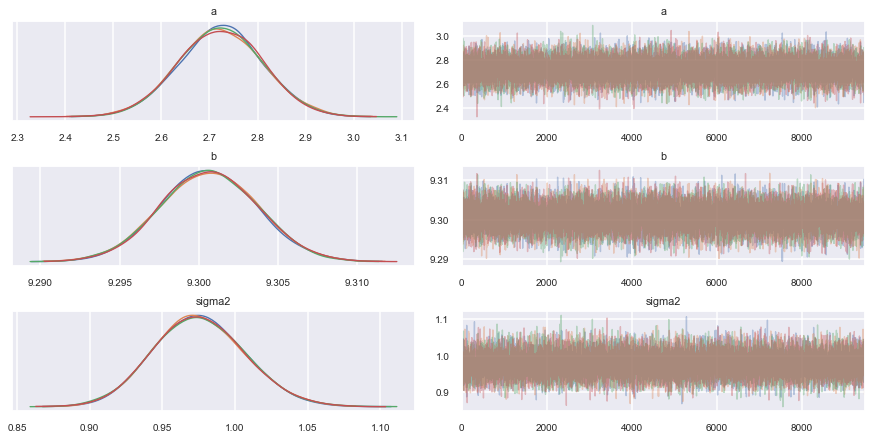

In [85]:
# Plot results #
sns.set()
sns.set_context("talk")
#fit.plot();
#az.plot_density(fit, var_names=["a", "b"]);
inference_data = az.from_pystan(posterior=fit);
az.plot_trace(inference_data);

-------------------------

## (ii) Gaussian mixture model

#### K mixture components and N data points

Parameters: $ \theta = \{ \mu_1,…,\mu_K,\sigma_1^2,…,\sigma_K^2, \phi_1,…,\phi_K \} $

(1) Probability that $x_n, n \leq N$ originates from component $k \leq K$:  

> $ p(z_n=k | \theta) = \phi_k $ with $ \sum_{k=1}^K \phi_k = 1$

(2) Probability of observing $x_n$ given that it comes from component (Gaussian) $k$:  

> $ p(x_n | z_n=k, \theta) = \mathcal{N}(x_n | \mu_k, \sigma_k^2) $


(3) Marginal probability of $x_n$:

> $ p(x_n | \theta) = \sum_{k=1}^K p(z_n=k | \theta) \, p(x_n | z_n=k, \theta) $


(1), (2), (3) $ \Rightarrow p(x_n | \theta) = \sum_{k=1}^K \phi_k \, \mathcal{N}(x_n | \mu_k, \sigma_k^2) $

(4) Likelihood L:

> $ L(x | \theta) = \Pi_{n=1}^N p(x_n | \theta) = \Pi_{n=1}^N  \sum_{k=1}^K \phi_k \, \mathcal{N}(x_n | \mu_k, \sigma_k^2) $

$\Rightarrow$ Log-Likelihood $ L(x | \theta) = \sum_{n=1}^N \log \left( \sum_{k=1}^K  \phi_k \, \mathcal{N}(x_n | \mu_k, \sigma_k^2) \right) $

##### Define model

In [3]:
gmm_model = """

// 1.) Data
data {
  int<lower=1> K;          // number of mixture components
  int<lower=1> N;          // number of data points
  vector[N] y;               // observations
}

// 2.) Parameters
parameters {
  simplex[K] z;              // mixing proportions, entries >=0 and sum = 1
  ordered[K] mu;             // locations of mixture components
  vector<lower=0>[K] sigma;  // scales of mixture components
}

// 3.) Model
model {
  vector[K] log_z = log(z);  // cache log calculation
  sigma ~ lognormal(0, 2);
  mu ~ normal(0, 10);
  for (n in 1:N) {
    vector[K] lps = log_z;
    for (k in 1:K)
      lps[k] += normal_lpdf(y[n] | mu[k], sigma[k]);
    target += log_sum_exp(lps);
  }
}

""" 

###### Actual dataset

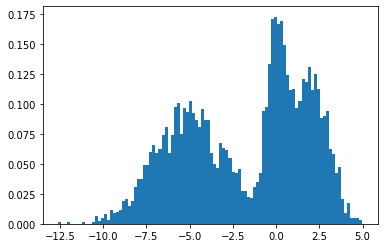

In [4]:
# Create dataset that we want to fit our model to #
N = 5000
mu = np.array([-5, 0, 2])
sigma = np.array([2, 0.5, 1])
K = len(mu)

# Coefficients #
z = np.array([0.5, 0.2, 0.3])
z /= z.sum()      # in case these did not add up to 1

# K normal distributions #
distributions = []
for i in range(K):
    distributions.append({"type": np.random.normal, "kwargs": {"loc": mu[i], "scale": sigma[i]}})

# Setup mixture model and sample from it #
data = np.zeros((N, K))
for idx, distr in enumerate(distributions):
    data[:, idx] = distr["type"](size=(N,), **distr["kwargs"])
random_idx = np.random.choice(np.arange(K), size=(N,), p=z)
sample = data[np.arange(N), random_idx]
plt.hist(sample, bins=100, density=True)
plt.show()

# Store dataset in dictionary #
data_dict = {'N': N,
             'K': K,
             'y': sample}

##### Fit our model against the actual dataset

In [ ]:
# Compile model #
model = pystan.StanModel(model_code=gmm_model)

# Train model and sample from posterior #
fit = model.sampling(data=data_dict, iter=10000, chains=2, warmup=500, seed=0)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41927516b4c27714793336b93fe6db9a NOW.


##### Check results

In [20]:
print(fit)

Inference for Stan model: anon_model_41927516b4c27714793336b93fe6db9a.
2 chains, each with iter=10000; warmup=500; thin=1; 
post-warmup draws per chain=9500, total post-warmup draws=19000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
z[1]       0.37    0.14   0.15   0.04   0.25   0.48    0.5   0.51      1   2.01
z[2]       0.22  2.0e-3   0.09   0.04    0.2   0.22   0.24   0.43   1834    1.0
z[3]       0.41    0.12   0.13   0.26   0.28   0.42   0.53   0.55      1  13.54
mu[1]     -5.54    0.54   0.65  -7.25  -5.88  -5.18  -5.05  -4.98      1   1.66
mu[2]     -2.26    2.32   2.33  -5.16  -4.61  -1.41   0.06    0.1      1   8.83
mu[3]      1.54    0.52   0.52   0.97   1.03   1.49   2.06   2.16      1   11.6
sigma[1]   1.92    0.07    0.2    1.6   1.82   1.95    2.0   2.19      7   1.08
sigma[2]   0.97    0.48   0.52   0.47   0.51   0.56   1.43   1.77      1   2.26
sigma[3]   1.21    0.22   0.22   0.92   0.99   1.25   1.42   1.47      1   7.36
lp__     -

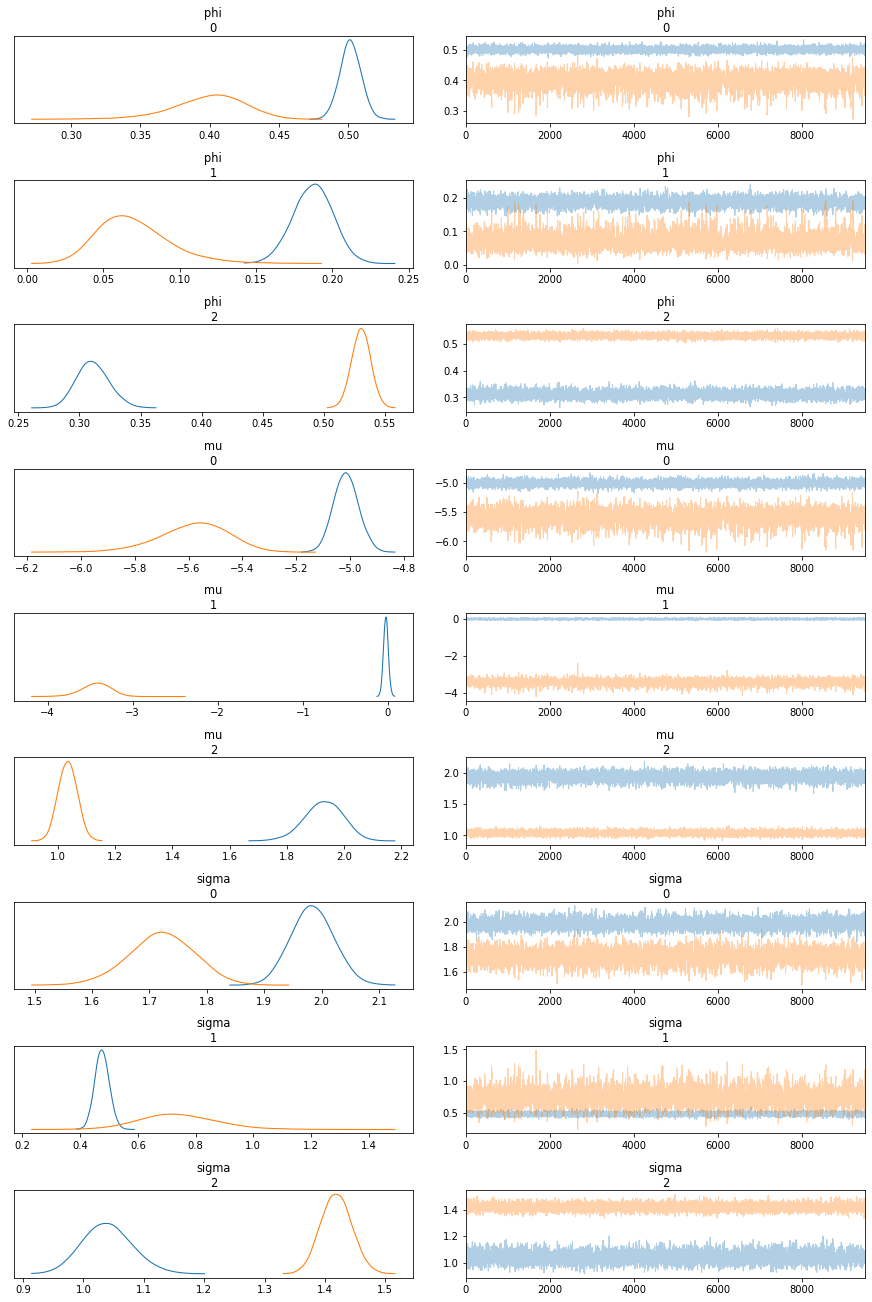

In [8]:
# Plot results #
inference_data = az.from_pystan(posterior=fit);
az.plot_trace(inference_data);

## References:
* B. Carpenter et al., Stan: A Probabilistic Programming Language
[http://www.stat.columbia.edu/~gelman/research/published/stan-paper-revision-feb2015.pdf]
* https://pystan.readthedocs.io/en/latest/getting_started.html
* https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53
* https://betanalpha.github.io/assets/case_studies/identifying_mixture_models.html
* https://mc-stan.org/docs/2_23/stan-users-guide/summing-out-the-responsibility-parameter.html
